# CNN model testing
Used to test audio that are mixes of songs and ads.

Requires saved models from either:
* `cnn_mfcc.ipynb`
* `cnn_raw.ipynb`

Requires audio from:
* `resampleAudio_testing.m`
* `resampleRun_testing.m`

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy
from scipy.io import wavfile

In [2]:
# Load audio file
song_dir = "resampled_testing_songs"
ad_dir   = "resampled_testing_ads"
sr = 44100
song_data = []
ad_data = []

In [4]:
# get songs
num_songs = 0
for filename in os.listdir(song_dir):
    # Check if the file is a WAV file
    if filename.endswith('.wav'):
        num_songs += 1
        # Construct the full path to the file
        filepath = os.path.join(song_dir, filename)
        [data, sr_dc] = librosa.load(filepath, sr=sr)
        song_data.append(data)
print(f"Num Songs is: {num_songs}")

Num Songs is: 4


In [5]:
# get ads
num_ads = 0
for filename in os.listdir(ad_dir):
    # Check if the file is a WAV file
    if filename.endswith('.wav'):
        num_ads += 1
        numClips = 0
        # Construct the full path to the file
        filepath = os.path.join(ad_dir, filename)
        [data, sr_dc] = librosa.load(filepath, sr=sr)
        ad_data.append(data)
print(f"Num Ads is: {num_ads}")

Num Ads is: 3


In [6]:
# Define our CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6784, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output into a 1D vector for use in the fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

In [7]:
# define get window function
def get_window(audio, begin, window_size):
    return audio[(begin):(begin+window_size)]

In [27]:
# load Model
model_name = "cnn_mfcc_model.pth"

# Load the state dictionary
state_dict = torch.load(model_name)

# Create an instance of model
model = CNN()

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model in evaluation mode
model.eval()

# Initialize parameters
seconds_per_window = 5

win_length = 5*sr

window_stride = song_win_length//10

audio = []
for i in range(len(song_data) + len(ad_data)):
    if(i % 2 == 0):
        audio.extend(song_data[i//2])
    else:
        audio.extend(ad_data[i//2])
audio = np.array(audio).astype(dtype=np.float32)
audio = np.pad(audio, (win_length, win_length), mode='constant')

print(f"audio length is: {audio.shape}")

audio length is: (44939861,)


In [28]:
wavfile.write(os.path.join("testing_audio", "complex.wav"), sr, audio)

In [29]:
# evaluate audio
temp = librosa.feature.mfcc(y=audio[0:win_length], sr=sr, n_mfcc=13)[1:].T
mfccs = np.empty((1, 1, temp.shape[0], temp.shape[1]), dtype=np.float32)
print(f"tensor shape: {mfccs.shape}")

audio_eval = []
song_confidence = []
ad_confidence = []

for i in range(0, len(audio) - song_win_length, window_stride):
    window = get_window(audio, i, song_win_length)
    mfccs[0,0] = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=13)[1:].T
    mfccs_tensor = torch.tensor(mfccs, dtype=torch.float32)
    output = model(mfccs_tensor)
    prediction = torch.max(output.data, 1)
    audio_eval.append([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence.append(output.data[0][0])
    song_confidence.append(output.data[0][1])

tensor shape: (1, 1, 431, 12)


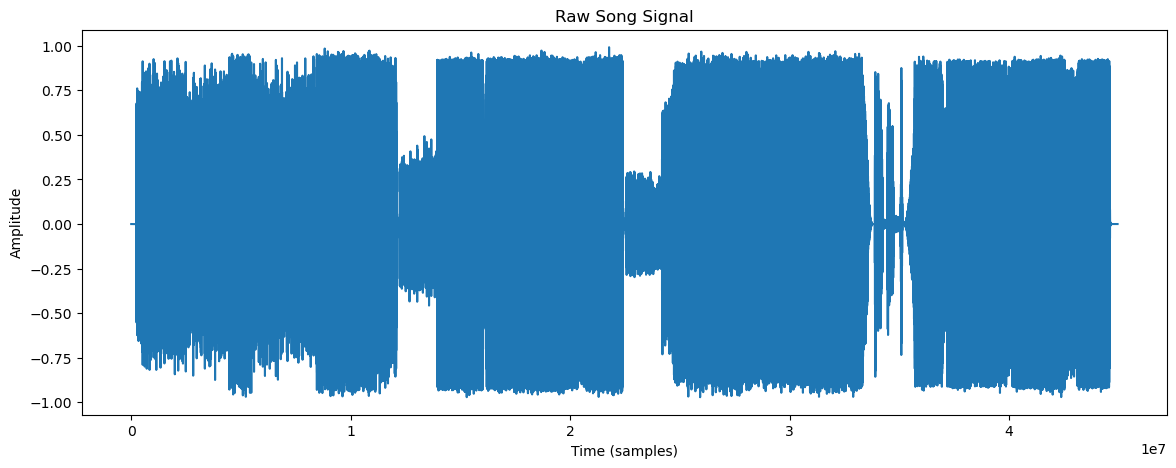

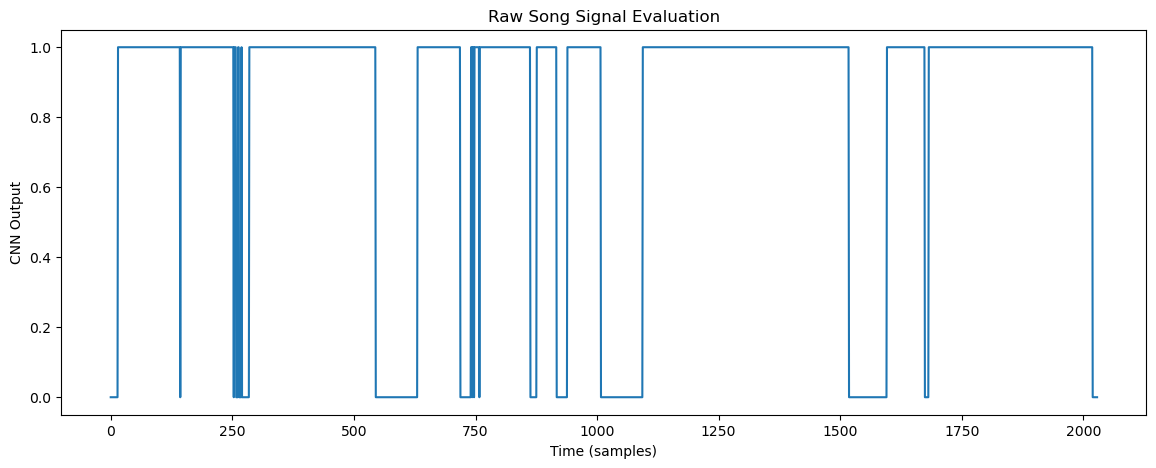

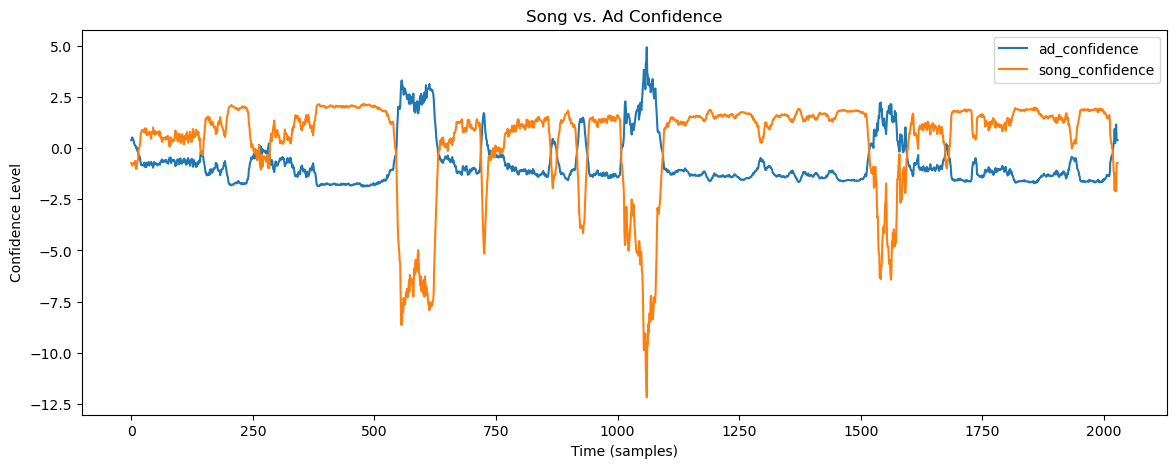

In [30]:
#plot song
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Raw Song Signal')
plt.show()

#plot eval
plt.figure(figsize=(14, 5))
plt.plot(audio_eval)
plt.xlabel('Time (samples)')
plt.ylabel('CNN Output')
plt.title('Raw Song Signal Evaluation')
plt.show()

#plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence, label='ad_confidence')
plt.plot(song_confidence, label='song_confidence')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
plt.ylabel('Confidence Level')
plt.title('Song vs. Ad Confidence')
plt.show()